In [12]:
import math

import matplotlib.pyplot as pl
import cv2
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans


# https://www.imdb.com/title/tt9433398/

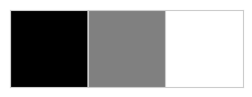

In [13]:
color_palette_2 = [
    [0, 0, 0],
    [128, 128, 128],
    [255, 255, 255],
]


def print_color_palette(color_palette):
    def rgb_to_hex(rgb):
        return '#%02x%02x%02x' % (rgb[0], rgb[1], rgb[2])

    color_pallete = [rgb_to_hex(color) for color in color_palette]
    sns.palplot(sns.color_palette(color_pallete))
    sns.color_palette()


print_color_palette(color_palette_2)

# Color Quantisation (Even Pallet)

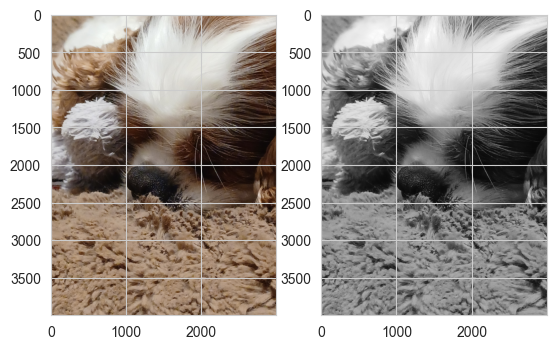

In [14]:
img_pepper = cv2.cvtColor(cv2.imread('img/example/Pepper.jpg'), cv2.COLOR_BGR2RGB)
img_pepper_grey = cv2.cvtColor(img_pepper, cv2.COLOR_RGB2GRAY)

subplot = pl.subplot(1, 2, 1)
subplot.imshow(img_pepper)
subplot = pl.subplot(1, 2, 2)
subplot.imshow(img_pepper_grey, cmap='gray')

In [15]:
def quantize_grey_image(img, n_colors=4):
    palette = np.linspace(0, 255, n_colors).astype(np.uint8)
    ret_img = np.zeros_like(img).astype(np.uint8)
    for i in range(n_colors):
        ret_img[img >= palette[i]] = palette[i]
    return ret_img, palette


def quantize_color_image(img, n_colors=4):
    palette = []
    for i in range(n_colors):
        for j in range(n_colors):
            for k in range(n_colors):
                palette.append([i * 255 // (n_colors - 1), j * 255 // (n_colors - 1), k * 255 // (n_colors - 1)])
    palette = np.array(palette).astype(np.uint8)

    ret_img = np.zeros_like(img).astype(np.uint8)
    for i in range(n_colors ** 3):
        ret_img[np.all(img >= palette[i], axis=-1)] = palette[i]
    return ret_img, palette


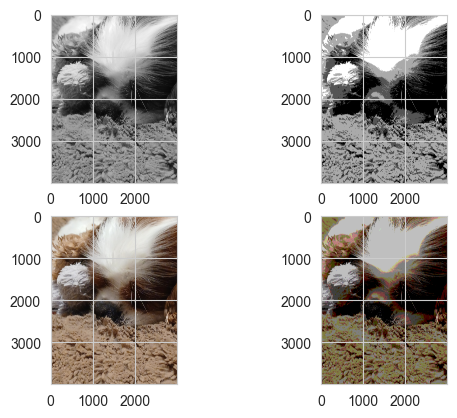

In [16]:
q_img_pepper_grey, grey_palette = quantize_grey_image(img_pepper_grey, 5)
q_img_pepper, color_palette = quantize_color_image(img_pepper, 5)

subplot = pl.subplot(2, 2, 1)
subplot.imshow(img_pepper_grey, cmap='gray')
subplot = pl.subplot(2, 2, 2)
subplot.imshow(q_img_pepper_grey, cmap='gray')
subplot = pl.subplot(2, 2, 3)
subplot.imshow(img_pepper)
subplot = pl.subplot(2, 2, 4)
subplot.imshow(q_img_pepper)

[  0  63 127 191 255]


5

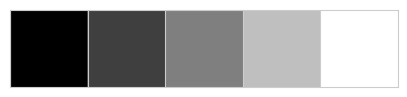

In [17]:
print(grey_palette)
grey_palette_rgb = [[col, col, col] for col in grey_palette]

print_color_palette(grey_palette_rgb)
len(grey_palette_rgb)

In [18]:
# print_color_palette(color_palette)
len(color_palette)

125

# Color Quantisation (Unique Pallet)

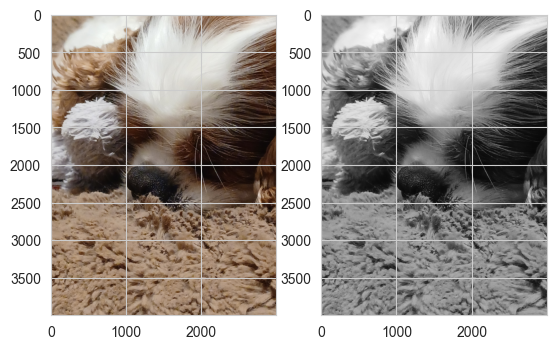

In [19]:
img_pepper = cv2.cvtColor(cv2.imread('img/example/Pepper.jpg'), cv2.COLOR_BGR2RGB)
img_pepper_grey = cv2.cvtColor(img_pepper, cv2.COLOR_RGB2GRAY)

subplot = pl.subplot(1, 2, 1)
subplot.imshow(img_pepper)
subplot = pl.subplot(1, 2, 2)
subplot.imshow(img_pepper_grey, cmap='gray')

In [20]:
def quantize_color_image_unique(img, n_colors=4):
    img = img.copy()
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(img.reshape(-1, 3))
    palette = kmeans.cluster_centers_.astype(np.uint8)

    ret_img = palette[kmeans.labels_].reshape(img.shape).astype(np.uint8)
    return ret_img, palette

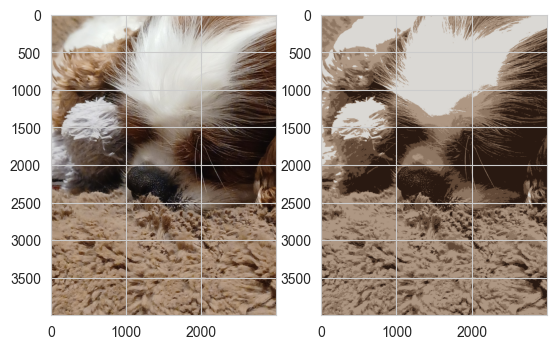

In [21]:
img_pepper_unique, color_palette_unique = quantize_color_image_unique(img_pepper, 5)

subplot = pl.subplot(1, 2, 1)
subplot.imshow(img_pepper)
subplot = pl.subplot(1, 2, 2)
subplot.imshow(img_pepper_unique)

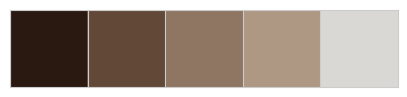

In [22]:
print_color_palette(sorted(color_palette_unique.tolist()))

# Ordered Dithering (Gray)

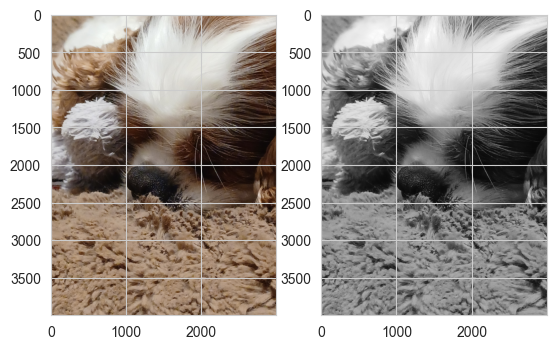

In [23]:
img_pepper = cv2.cvtColor(cv2.imread('img/example/Pepper.jpg'), cv2.COLOR_BGR2RGB)
img_pepper_grey = cv2.cvtColor(img_pepper, cv2.COLOR_RGB2GRAY)

subplot = pl.subplot(1, 2, 1)
subplot.imshow(img_pepper)
subplot = pl.subplot(1, 2, 2)
subplot.imshow(img_pepper_grey, cmap='gray')

In [24]:
def dither_matrix(n: int):
    if n == 1:
        return np.array([[0]])
    else:
        first = (n ** 2) * dither_matrix(int(n / 2))
        second = (n ** 2) * dither_matrix(int(n / 2)) + 2
        third = (n ** 2) * dither_matrix(int(n / 2)) + 3
        fourth = (n ** 2) * dither_matrix(int(n / 2)) + 1
        first_col = np.concatenate((first, third), axis=0)
        second_col = np.concatenate((second, fourth), axis=0)
        return (1 / n ** 2) * np.concatenate((first_col, second_col), axis=1)


dither_matrix(8)

array([[0.      , 0.5     , 0.125   , 0.625   , 0.03125 , 0.53125 ,
        0.15625 , 0.65625 ],
       [0.75    , 0.25    , 0.875   , 0.375   , 0.78125 , 0.28125 ,
        0.90625 , 0.40625 ],
       [0.1875  , 0.6875  , 0.0625  , 0.5625  , 0.21875 , 0.71875 ,
        0.09375 , 0.59375 ],
       [0.9375  , 0.4375  , 0.8125  , 0.3125  , 0.96875 , 0.46875 ,
        0.84375 , 0.34375 ],
       [0.046875, 0.546875, 0.171875, 0.671875, 0.015625, 0.515625,
        0.140625, 0.640625],
       [0.796875, 0.296875, 0.921875, 0.421875, 0.765625, 0.265625,
        0.890625, 0.390625],
       [0.234375, 0.734375, 0.109375, 0.609375, 0.203125, 0.703125,
        0.078125, 0.578125],
       [0.984375, 0.484375, 0.859375, 0.359375, 0.953125, 0.453125,
        0.828125, 0.328125]])

In [25]:
def ordered_dithering(img: np.array, dither_m: np.array):
    img = img.copy() / 255
    ret_img = np.zeros_like(img)
    n = np.size(dither_m, axis=0)
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            i = x % n
            j = y % n
            if img[y][x] > dither_m[i][j]:
                ret_img[y][x] = 255
            else:
                ret_img[y][x] = 0
    return ret_img

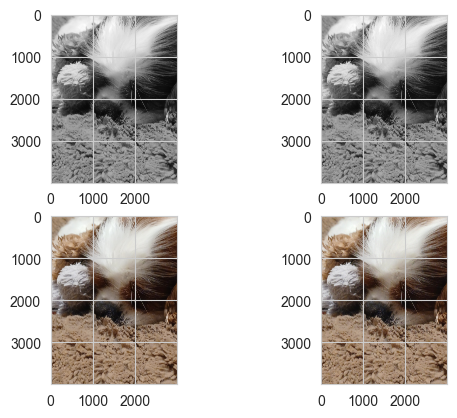

In [26]:
d_pepper_grey = ordered_dithering(img_pepper_grey, dither_matrix(8))

d_img_pepper = np.zeros_like(img_pepper)
for i in range(3):
    d_img_pepper[:, :, i] = ordered_dithering(img_pepper[:, :, i], dither_matrix(8))

subplot = pl.subplot(2, 2, 1)
subplot.imshow(img_pepper_grey, cmap='gray')
subplot = pl.subplot(2, 2, 2)
subplot.imshow(d_pepper_grey, cmap='gray')
subplot = pl.subplot(2, 2, 3)
subplot.imshow(img_pepper)
subplot = pl.subplot(2, 2, 4)
subplot.imshow(d_img_pepper)

In [27]:
# export image to file
cv2.imwrite('output/notebook/Pepper_grey_dithered.jpg', d_pepper_grey)
cv2.imwrite('output/notebook/Pepper_color_dithered.jpg', cv2.cvtColor(d_img_pepper, cv2.COLOR_RGB2BGR))

True

# Making Pixel Art

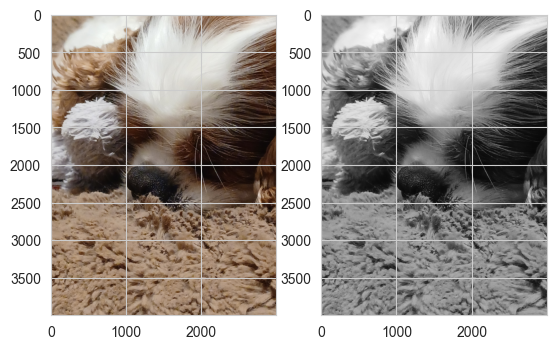

In [28]:
img_pepper = cv2.cvtColor(cv2.imread('img/example/Pepper.jpg'), cv2.COLOR_BGR2RGB)
img_pepper_grey = cv2.cvtColor(img_pepper, cv2.COLOR_RGB2GRAY)

subplot = pl.subplot(1, 2, 1)
subplot.imshow(img_pepper)
subplot = pl.subplot(1, 2, 2)
subplot.imshow(img_pepper_grey, cmap='gray')

## The Naive Approach

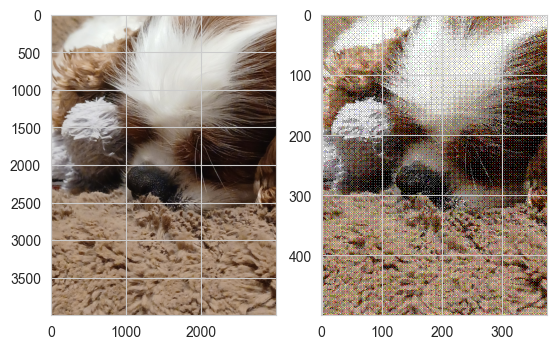

In [29]:
def generate_pixel_art_simple(img: np.array, dither_m: np.array, n_colors: int, downscale: int = 1):
    img = img.copy()
    img = cv2.resize(img, (img.shape[1] // downscale, img.shape[0] // downscale))
    d_img = np.zeros_like(img)
    for i in range(3):
        d_img[:, :, i] = ordered_dithering(img[:, :, i], dither_m)
    return d_img


d_img_pepper = generate_pixel_art_simple(img_pepper, dither_matrix(8), 3, 8)

subplot = pl.subplot(1, 2, 1)
subplot.imshow(img_pepper)
subplot = pl.subplot(1, 2, 2)
subplot.imshow(d_img_pepper)

## Dithering between Colors

In [30]:
rel_dist_next_color = 0
sigmoided = 1 / (1 + math.exp(-(rel_dist_next_color - 0.5) * 20))

rel_dist_next_color, sigmoided

(0, 4.5397868702434395e-05)

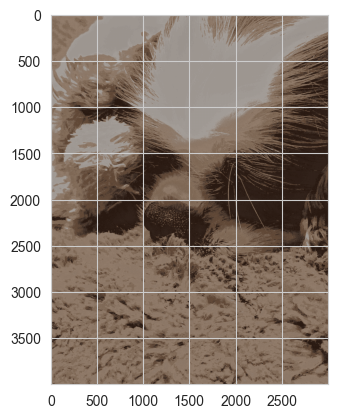

In [31]:
def generate_pixel_art(img: np.array, dither_m: np.array, n_colors: int, downscale: int = 1, temperature: float = 20):
    img = img.copy()
    # img = cv2.resize(img, (img.shape[1] // downscale, img.shape[0] // downscale))
    q_img, palette = quantize_color_image_unique(img, n_colors)
    sorted_palette = sorted(palette.tolist())
    sorted_palette.reverse()
    d_img = np.ones_like(img).astype('int')

    d_img *= sorted_palette[0]

    for i in range(len(sorted_palette) - 1):
        sub_img = np.zeros_like(img)
        current_color = sorted_palette[i]
        next_color = sorted_palette[i + 1]

        n = np.size(dither_m, axis=0)
        for x in range(img.shape[1]):
            for y in range(img.shape[0]):
                i = x % n
                j = y % n

                distance_current_color = math.sqrt(sum(img[y][x] - current_color) ** 2)
                distance_next_color = math.sqrt(sum(img[y][x] - next_color) ** 2)
                rel_dist_next_color = distance_current_color / (distance_current_color + distance_next_color)
                sigmoided = 1 / (1 + math.exp(-(rel_dist_next_color - 0.5) * temperature))

                if sigmoided > dither_m[i][j]:
                    sub_img[y][x] = 255
                else:
                    sub_img[y][x] = 0
        # where one multiply with next color and overlay over d_img
        d_img = np.where(sub_img == 255, next_color, d_img)

    return d_img, palette


# img_pepper_small = cv2.resize(img_pepper, (img_pepper.shape[1] // 8, img_pepper.shape[0] // 8))
temp_img, palette = generate_pixel_art(img_pepper, dither_matrix(8), n_colors=5, downscale=1, temperature=10)

pl.imshow(temp_img)

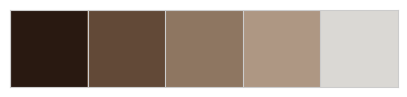

In [32]:
print_color_palette(sorted(palette.tolist()))

In [33]:
# export image to file
cv2.imwrite('output/notebook/Pepper_pixel_art.png', cv2.cvtColor(temp_img.astype('uint8'), cv2.COLOR_RGB2BGR))

True